# Supervised surface water mapping using Sentinle-1 backscatter

This notebook gives an example of applying a supervised ML classifier to map surface water. The classifier uses three features, VV, VH and VH/VV, and is trained with labels from Water Observation from Space classifications for clear Landsat observations. 

The model used is trained on data over Menindee Lakes in south-west NSW, Australia. A locally trained model may perform better but this example shows it's possible to generalize.

Similar to the thesholding method, this model fails to classify water in windy conditions.

Following steps are demonstrated:
1. [Load Sentinel-1 data through the datacube API](#load)
2. [Apply speckle filtering to the data](#speckle)
3. [Apply a trained supervised model ](#classify)
4. [Visualize the result and compare to other methods](#result)

The code below makes use of the datacube API and requires that:
* Sentinel-1 backscatter for VV and VH polarizations are processed using SNAP.
* Data are indexed as product 's1_gamma0_scene_v2' in a datacube database that's configured in radar.conf


## 1. Load Sentinel-1 data through the datacube API  <a name="load"></a>

Area of interest is Lake George, an endorheic lake in south-eastern New South Wales, Australia.

In [1]:
%matplotlib inline
import numpy as np
import datacube

In [2]:
dc = datacube.Datacube(config='radar.conf')

In [3]:
# Define area and time period of interest

query = {
'y': (-35.217575569215505, -34.97543887925878), 
'x': (149.2719268798828, 149.5095062255859),
'time':('2017-09-01','2017-12-01'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (25, -25)
}

In [4]:
radar = dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', **query)

In [5]:
# select scenes covering at least 50% of the area
total_px=len(radar.x)*len(radar.y)
valid=radar.where(radar.vv!=0).where(radar.vh!=0).count(dim=('x','y'))
good=(valid.vh/total_px)>0.5
radar = radar.sel(time=good)

In [6]:
# replace 0 with nan
radar = radar.where(radar!=0)

In [7]:
radar

<xarray.Dataset>
Dimensions:  (time: 7, x: 1003, y: 1185)
Coordinates:
  * time     (time) datetime64[ns] 2017-09-05T19:15:50.607985 ... 2017-11-28T19:15:51.133110
  * y        (y) float64 -3.955e+06 -3.955e+06 ... -3.926e+06 -3.926e+06
  * x        (x) float64 1.589e+06 1.589e+06 1.589e+06 ... 1.564e+06 1.564e+06
Data variables:
    vh       (time, y, x) float32 0.048105452 0.023859339 ... 0.00062273693
    vv       (time, y, x) float32 0.22519502 0.09242475 ... 0.04959599
Attributes:
    crs:      EPSG: 3577

## 2. Apply speckle filtering to the data <a name="speckle"></a>

With options to remove/reduce negative and extremely high backscatter values.

In [8]:
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

In [9]:
from scipy.ndimage import grey_dilation, grey_erosion
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.morphology import disk

def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    Option to fill negative pixel with grey_dilation
    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    
    return img_output


def denoise(ds, verbose = False, bands = None, fill_negative = True, remove_high = False):
    """
    Apply lee filter to a S1 dataset loaded from datacube.
    Keep nodata pixels as lee filter implemnation doesn't consider nan
    """
    if not bands: bands = list(ds.data_vars)    
    # save the nodata mask
    zero_mask = (ds==0).to_array().any(axis=0)
    nan_mask = (np.isnan(ds)).to_array().any(axis=0)
    nodata_mask = zero_mask | nan_mask
    ds = ds.where(~nodata_mask, 0)
    smoothed = ds[bands[0]].groupby('time').apply(lee_filter, size=7).to_dataset(name=bands[0])
    for band in bands[1:]: smoothed[band] = ds[band].groupby('time').apply(lee_filter, size=7)
        
    if fill_negative:
        # reduce impact of negative pixels
        for band in bands:
            dilated = smoothed[band].groupby('time').apply(grey_dilation, footprint=disk(3))
            smoothed[band] = smoothed[band].where(smoothed[band] > 0, dilated)

    if verbose:
        for band in bands: print("# of negative pixels in %s:"%band, (smoothed[band]<0).sum().values)

    if remove_high:
        # reduce extreme outliers 
        for band in bands:
            eroded = smoothed[band].groupby('time').apply(grey_erosion, size=(3,3))
            smoothed[band] = smoothed[band].where(smoothed[band] < eroded.max(), eroded)

    return smoothed.where(~nodata_mask)


In [10]:
clean = denoise(radar)

## 3. Apply a trained supervised model <a name="classify"></a>

In [11]:
from joblib import dump, load

#load the trained model
clf=load('rusboost_menindee.joblib') 

In [12]:
# adding vh_over_vv feature
clean['vh_over_vv']=clean.vh/clean.vv

In [13]:
features = ['vv','vh','vh_over_vv']
data = clean[features].to_array(dim='variable').transpose('x','y','time', 'variable').values
orig_shape = data.shape
data = data.reshape(orig_shape[0]*orig_shape[1]*orig_shape[2],orig_shape[3])

In [14]:
bad = np.isnan(data).any(axis=-1)
data[bad,:]=0
classified = clf.predict(data)
classified[bad] = np.nan
clean['water'] = ('time','y','x'), classified.reshape(orig_shape[:-1]).transpose()

In [15]:
# exclude dates when model fails to detect water

fail = (clean['water'].groupby('time').mean() < 0.01).values

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


In [16]:
for i in np.arange(len(clean.time))[fail]:
    clean['water'][i,:,:] = np.nan

## 4. Inspect results and compare to optical detections <a name="result"></a>

Visualize and use the classification results to
* caculate water detection frequecy for each pixel in the area and compare to optical detections
* estimate monthly filled fractions for the largest water body

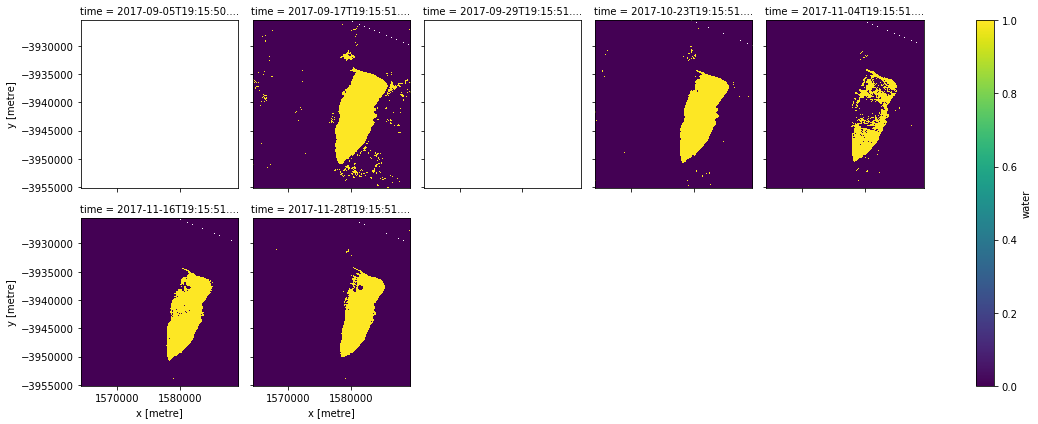

In [17]:
clean.water.plot.imshow(col='time', col_wrap=5)

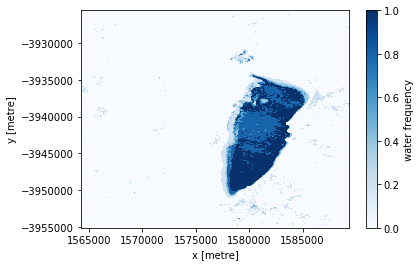

In [18]:
# detection frequency 
s1_water_freq = clean.water.mean(dim='time').rename('water frequency')
s1_water_freq.plot(cmap='Blues')

In [19]:
import xarray as xr
s1_thresh_freq = xr.open_dataset('s1_water.nc').water.mean(dim='time').rename('water frequency')

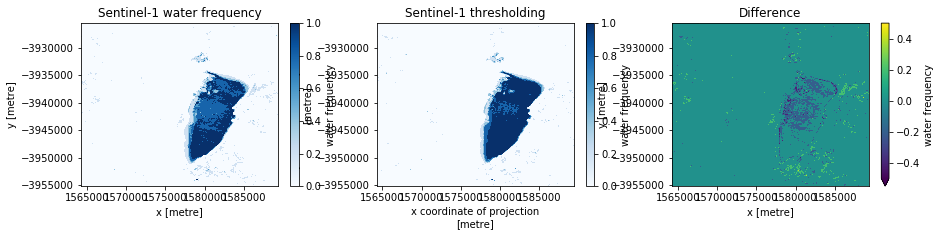

In [20]:
f, axes = plt.subplots(1,3, figsize=(15,3))

s1_water_freq.plot(cmap='Blues', ax = axes[0])
axes[0].set_title('Sentinel-1 water frequency');

s1_thresh_freq.plot(cmap='Blues', ax = axes[1])
axes[1].set_title('Sentinel-1 thresholding');

# difference between two methods
(s1_water_freq-s1_thresh_freq).plot(vmin=-0.5, vmax=0.5, ax = axes[2])
axes[2].set_title('Difference');

In [21]:
# load Water Observation from Space classifications from Digital Earth Australia

from digitalearthau.utils import wofs_fuser

prod_dc = datacube.Datacube()
wofs = prod_dc.load(product='wofs_albers', group_by='solar_day', fuse_func=wofs_fuser, **query)

# Only include clear detections
clear = np.isin(wofs.water, [0,128])
wofs_clear = (wofs==128).where(clear)
wofs_freq = wofs_clear.water.mean(dim='time')

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


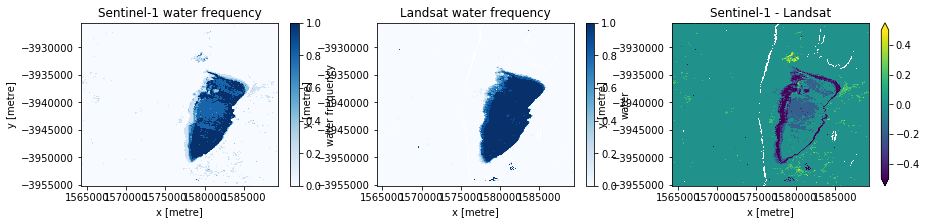

In [22]:
f, axes = plt.subplots(1,3, figsize=(15,3))

s1_water_freq.plot(cmap='Blues', ax = axes[0])
axes[0].set_title('Sentinel-1 water frequency');

wofs_freq.plot(cmap='Blues', ax = axes[1])
axes[1].set_title('Landsat water frequency');

# difference between S1 and Landsat wofs
(s1_water_freq-wofs_freq).plot(vmin=-0.5, vmax=0.5, ax = axes[2])
axes[2].set_title('Sentinel-1 - Landsat');

# lake edge is consitenly missed by Sentinel-1 due to high backscatter

In [23]:
# find the largest water body

from rasterio import features
from shapely.geometry import shape

def find_largest_water(wofs):
    max_water = 0
    for fshape, value in features.shapes((wofs>0).values.astype('int16'), mask=(wofs>0).values):
        geom=shape(fshape)
        if geom.area>max_water:
            max_water = geom.area
            water_body = geom
    return water_body

lake = find_largest_water(wofs_freq)
lake_mask = features.geometry_mask([lake], (len(clean.x), len(clean.y)), (0,1,0,1,0,1), invert = True)

In [24]:
clean['lake'] = ('time','y','x'), lake_mask.transpose()[np.newaxis,:,:].repeat(len(clean.time), axis=0)

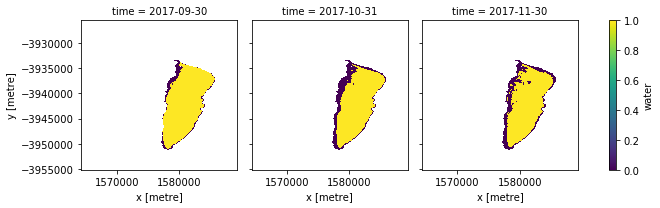

In [25]:
# monthly aggregate as detected any time in the month (reduce weather impact)

monthly = clean.water.to_dataset().resample(time = "M").mean(skipna=True)
monthly = (monthly >= 0.1)*1.
monthly.where(clean.lake.isel(time=0)).water.plot.imshow(col='time');

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


[0.902759   0.78275872 0.76549894]


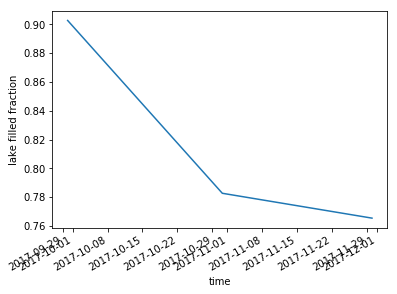

In [26]:
# filled fractions
water_fraction = monthly.where(clean.lake.isel(time=0)).water.groupby('time').mean().rename('lake filled fraction')
print(water_fraction.values)
water_fraction.plot();

## 5. Save classification results as a netcdf file <a name="save"></a>

In [27]:
# Save output to file
import os
outputfile = 's1_water_supervised.nc'
if os.path.exists(outputfile): os.remove(outputfile)
water = clean.water.to_dataset(name='water')
dataset_to_output =  water.assign_attrs(radar.attrs)
datacube.drivers.netcdf.write_dataset_to_netcdf(dataset_to_output, outputfile)